<div class="alert alert-success">
<b>Reviewer's comment </b>
  
Thanks for taking the time to work on the project! It's accepted. Good luck on the next sprint!
  
</div>

**Review**
  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Business Goal

1. Train different models with various hyperparameters and to compare gradient boosting methods with random forest, decision tree, and linear regression.
2. Analyze the speed and quality of the models.
3. Use the RMSE metric to evaluate the models.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost as cb
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import timeit
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
try:
    rust_df = pd.read_csv('https://code.s3.yandex.net/datasets/car_data.csv')
except:
    rust_df = pd.read_csv('/datasets/car_data.csv')

In [3]:
def data_info(df):
    """Takes the dataset and provides summary info about the it."""
    print('Head:')
    display(df.head())
    print('--End--')
    print()
    print('Info:')
    display(df.info())
    print('--End--')
    print()
    print('Isnull:')
    display(df.isnull().sum()/df.shape[0])
    print('--End--')
    print()
    print('Duplicates:')
    display(df.duplicated().sum())
    print('--End--')
    print()
    print('Describe:')
    print(df.describe())
    
def eval_cal(y_test,y_predicted):
    """Takes the y_true and y_predicted to 
        compute the rmse of the model."""
    return mean_squared_error(y_test,y_predicted)**0.5    

def linear_reg(x_train, x_test,y_train, y_test):
    """Based on linearRegression, the function takes the 
        datasets for training and testing and returns the 
        rmse after scaling and training of the model."""
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    lr = LinearRegression().fit(x_train,y_train)
    y_predicted = lr.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))  
    
def Decisiontree(x_train, x_test,y_train, y_test):
    """Based on DecisionTreeRegressrion, the function 
        takes the datasets for training and testing and 
        returns the rmse using the best params from gridsearch."""
    params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
    g_cv = GridSearchCV(DecisionTreeRegressor(random_state=123),
                        param_grid=params,scoring='neg_root_mean_squared_error',
                        cv=5,refit=True)
    g_cv.fit(x_train, y_train)
    best_params = g_cv.best_params_
    dtr = DecisionTreeRegressor(**best_params).fit(x_train, y_train)
    y_predicted = dtr.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))

def RandomForestReg(x_train, x_test,y_train, y_test):
    """Based on RandomForestRegression, the function takes the 
        features and target sets. It then searches and uses
        best parameters for the rmse computation."""
    params = {'min_samples_split': range(2, 10, 2), 
              'max_depth': range(4,8,2), 'n_estimators':range(1,50,10)}
    g_cv = GridSearchCV(RandomForestRegressor(random_state=123),
                        param_grid=params,scoring='neg_root_mean_squared_error', 
                        cv=5,refit=True)
    g_cv.fit(x_train, y_train)
    best_params = g_cv.best_params_
    rfr = RandomForestRegressor(**best_params).fit(x_train, y_train)
    y_predicted = rfr.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))
    
def xgb(x_train, x_test,y_train, y_test):
    """This function based on XGBoosting, searches for the best params 
        using gridsearchCV and returns the rmse of the model."""
    params = {'max_depth': [4,8],
              'objective':['reg:squarederror'],
              'learning_rate':[0.1]}
    g_cv = GridSearchCV(XGBRegressor(treemethod='gpu_hist',gpu_id=0,random_state=123),
                        param_grid=params,
                        scoring='neg_root_mean_squared_error', cv=5,verbose=False)
    g_cv.fit(x_train, y_train)
    xgbr = XGBRegressor(**g_cv.best_params_)
    xgbr.fit(x_train,y_train,eval_set=[(x_test,y_test)], eval_metric='rmse')
    y_predicted = xgbr.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))
    
def catboostR(x_train, x_test,y_train, y_test):
    """This function base on Catboosting, uses the 
        different paramenters to compute the rmse of the model."""
    params = {'iterations': [10, 15, 20],
              'learning_rate': [0.03, 0.1],
              'depth': [2, 4, 6, 8],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]}
    cat = CatBoostRegressor(loss_function='RMSE',random_state=123,metric_period=5)
    cat.grid_search(params, train_dataset)
    y_predicted = cat.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))
    
def Lightgbmreg(x_train,x_test,y_train,y_test):
    """This function base on LGBM, searches for the best params 
        using gridsearchCV and returns the rmse of the model."""
    params = {'learning_rate': [0.1],
              'max_depth': [6,8],
              'n_estimator':[100,400]}
    g_cv = GridSearchCV(LGBMRegressor(random_state=123),
                        scoring='neg_root_mean_squared_error',
                        param_grid=params, cv=5)
    g_cv.fit(x_train, y_train)
    lgbm = LGBMRegressor(**g_cv.best_params_)
    lgbm.fit(x_train,y_train,categorical_feature=feature_categorical,verbose=1)           
    y_predicted = lgbm.predict(x_test)
    rmse = eval_cal(y_test,y_predicted)
    print(f'RMSE: {rmse:.2f}')
    print("time {}".format(timeit.timeit()))

In [4]:
data_info(rust_df)

Head:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


--End--

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

--End--

Isnull:


DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Mileage              0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

--End--

Duplicates:


262

--End--

Describe:
               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000        

There are some missing and duplicates values in the dataset. With some missing values being as high as 20% of the column. The description of the data also shows some outliers in registration year and power. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

In [5]:
rust_df.columns =rust_df.columns.str.lower()

In [6]:
# dropping these columns 
rust_df= rust_df.drop(['datecrawled','datecreated','postalcode','lastseen'],axis=1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

These column indeed don't seem predictive of our target

</div>

In [7]:
rust_df = rust_df.query('registrationyear >=1980 and registrationyear <= 2021')

In [8]:
rust_df.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures
count,350812.000000,350812.000000,350812.000000,350812.000000,350812.000000,350812.0
mean,4394.089045,2003.423021,110.418603,128679.492150,5.730095,0.0
std,4494.818733,6.611317,188.270170,37415.776776,3.725047,0.0
min,0.000000,1980.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6300.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0


In [9]:
rust_df.isnull().sum()/rust_df.shape[0]

price                0.000000
vehicletype          0.105316
registrationyear     0.000000
gearbox              0.054149
power                0.000000
model                0.053553
mileage              0.000000
registrationmonth    0.000000
fueltype             0.091428
brand                0.000000
notrepaired          0.199295
numberofpictures     0.000000
dtype: float64

In [10]:
cols = rust_df.columns
for col in rust_df[cols].select_dtypes('object').columns:
    rust_df.loc[rust_df[col].isna(),col]='None'

In [11]:
rust_df.isnull().sum()/rust_df.shape[0]

price                0.0
vehicletype          0.0
registrationyear     0.0
gearbox              0.0
power                0.0
model                0.0
mileage              0.0
registrationmonth    0.0
fueltype             0.0
brand                0.0
notrepaired          0.0
numberofpictures     0.0
dtype: float64

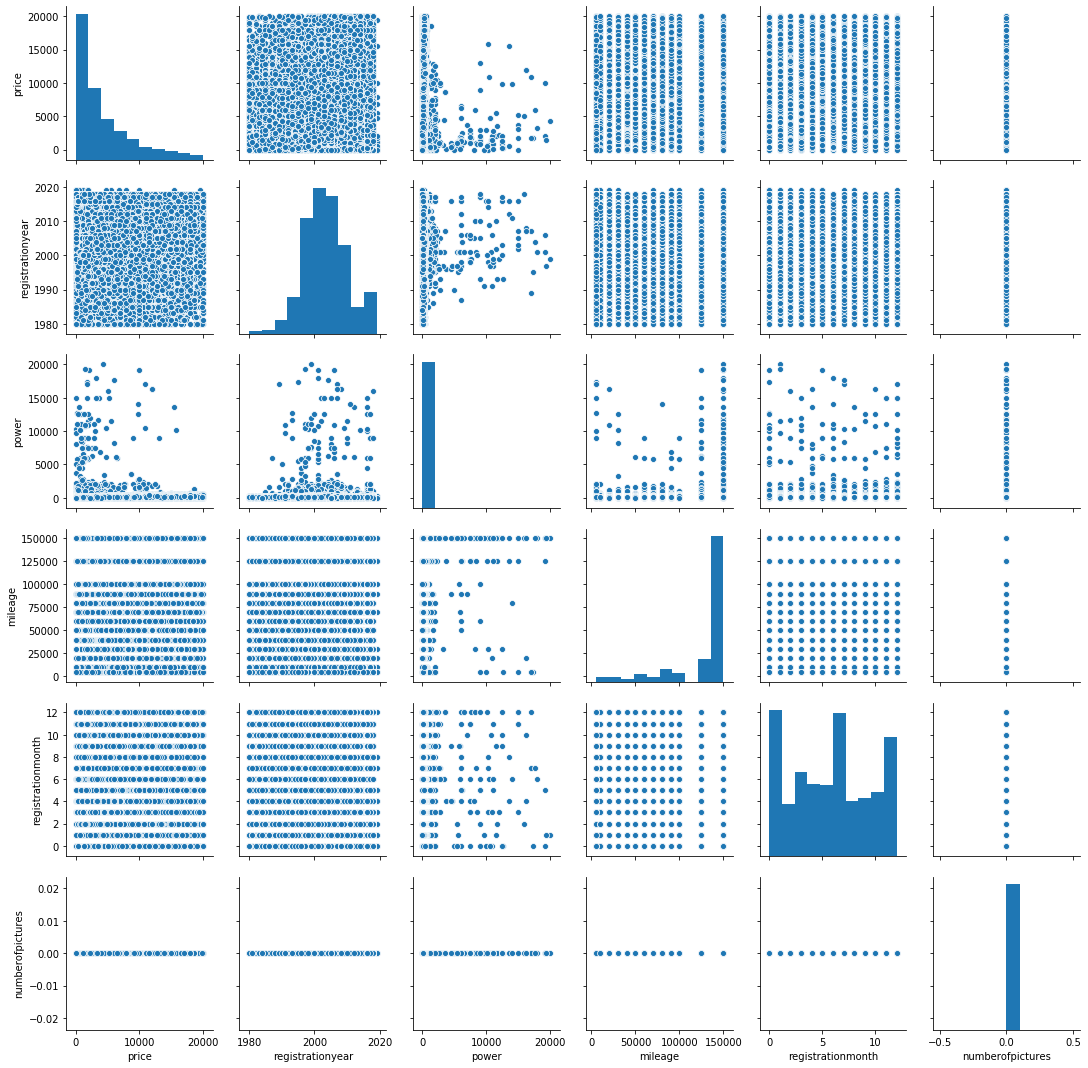

In [12]:
sb.pairplot(rust_df);

In [13]:
rust_df_corr = rust_df.corr()
rust_df_corr

,price,registrationyear,power,mileage,registrationmonth,numberofpictures
price,1.000000,0.451243,0.161994,-0.337664,0.111346,NaN
registrationyear,0.451243,1.000000,0.031756,-0.261632,0.034248,NaN
power,0.161994,0.031756,1.000000,0.021465,0.042437,NaN
mileage,-0.337664,-0.261632,0.021465,1.000000,0.002816,NaN
registrationmonth,0.111346,0.034248,0.042437,0.002816,1.000000,NaN
numberofpictures,NaN,NaN,NaN,NaN,NaN,NaN


# Conclusion
All the columns with null values have been filled with none as there are no clear approach to filling them in and attempt to drop them would reduce the data volumn dratically. Secondly, The registration year column has also been filtered out for cars between 1980 and 2020 thereby removing all outliers for the column.

Registration year has a positive moderate correlation with price as against mileage with a negative correlation. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, great, you did a small EDA, filled the missing values and filtered outliers in the registration year column

</div>

## Model training

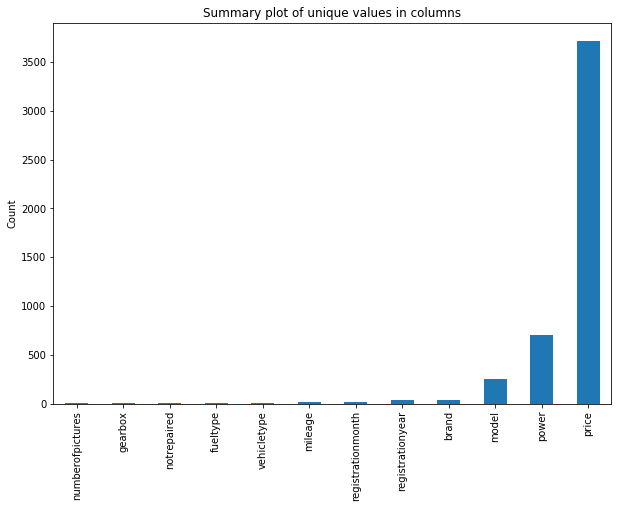

In [14]:
rust_df.nunique().sort_values().plot(kind='bar',figsize=(10,7))
plt.title('Summary plot of unique values in columns')
plt.ylabel('Count');

In [15]:
feature_categorical = [
    'vehicletype',
    'gearbox',
    'model',
    'fueltype','brand',
    'notrepaired']

In [16]:
rust_df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,numberofpictures
0,480,None,1993,manual,0,golf,150000,0,petrol,volkswagen,None,0
1,18300,coupe,2011,manual,190,None,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,None,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


In [17]:
rust_df_ord = rust_df.copy()
rust_df_ord[feature_categorical] = OrdinalEncoder().fit_transform(rust_df_ord[feature_categorical])
rust_df_ord

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,numberofpictures
0,480,0.0,1993,2.0,0,117.0,150000,0,7.0,38.0,0.0,0
1,18300,3.0,2011,2.0,190,26.0,125000,5,3.0,1.0,2.0,0
2,9800,7.0,2004,1.0,163,118.0,125000,8,3.0,14.0,0.0,0
3,1500,6.0,2001,2.0,75,117.0,150000,6,7.0,38.0,1.0,0
4,3600,6.0,2008,2.0,69,102.0,90000,7,3.0,31.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,0.0,2005,2.0,0,79.0,150000,7,7.0,22.0,2.0,0
354365,2200,0.0,2005,0.0,0,26.0,20000,1,0.0,33.0,0.0,0
354366,1199,2.0,2000,1.0,101,107.0,125000,3,7.0,32.0,1.0,0
354367,9200,1.0,1996,2.0,102,224.0,150000,3,3.0,38.0,1.0,0


In [18]:
# seperates the features from the target 
target = rust_df_ord.price
features = rust_df_ord.drop('price',axis=1)

# spliting of the dataset into train and test sets
x_train_ord,x_test_ord,y_train_ord,y_test_ord = train_test_split(features,target,test_size=0.25,random_state=123)

# print out the percentage ratio of each set.
print(f"Train = {100*len(x_train_ord)/len(rust_df_ord):.2f}%")
print(f"Test = {100*len(x_test_ord)/len(rust_df_ord):.2f}%")

Train = 75.00%
Test = 25.00%


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test set. The proportions are reasonable.

</div>

## Linear Regression

In [19]:
%%time
linear_reg(x_train_ord, x_test_ord,y_train_ord, y_test_ord)

RMSE: 3694.39
time 0.00980730727314949
CPU times: user 162 ms, sys: 107 ms, total: 269 ms
Wall time: 271 ms


## Decision Tree Regression

In [20]:
%%time
Decisiontree(x_train_ord, x_test_ord,y_train_ord, y_test_ord)

RMSE: 2387.10
time 0.006053324788808823
CPU times: user 10.7 s, sys: 53 ms, total: 10.8 s
Wall time: 10.9 s


## Random Forest Regression

In [21]:
%%time
RandomForestReg(x_train_ord, x_test_ord,y_train_ord, y_test_ord)

RMSE: 2327.30
time 0.00684332475066185
CPU times: user 11min 11s, sys: 416 ms, total: 11min 12s
Wall time: 11min 12s


## Conclusion
**Summary Results:** 

|Model |RMSE |Time|CPU Total time|
| ---- |---|---|---|
|Linear Regression | 3694.39 |0.010|269ms|
|Decision Tree | 2387.10 |0.014|10.8s|
|Random Forest | 2327.30| 0.007|11min 12s|


The best among these three is random forest in terms of rmse result but with the most time spent training the model.

## XGBoost

In [22]:
%%time
xgb(x_train_ord, x_test_ord,y_train_ord, y_test_ord)

[0]	validation_0-rmse:5753.14
[1]	validation_0-rmse:5265.75
[2]	validation_0-rmse:4833.67
[3]	validation_0-rmse:4452.31
[4]	validation_0-rmse:4115.03
[5]	validation_0-rmse:3817.54
[6]	validation_0-rmse:3556.87
[7]	validation_0-rmse:3327.42
[8]	validation_0-rmse:3128.47
[9]	validation_0-rmse:2956.16
[10]	validation_0-rmse:2805.03
[11]	validation_0-rmse:2674.48
[12]	validation_0-rmse:2562.58
[13]	validation_0-rmse:2465.77
[14]	validation_0-rmse:2381.72
[15]	validation_0-rmse:2306.67
[16]	validation_0-rmse:2244.32
[17]	validation_0-rmse:2190.94
[18]	validation_0-rmse:2145.55
[19]	validation_0-rmse:2106.53
[20]	validation_0-rmse:2071.43
[21]	validation_0-rmse:2041.51
[22]	validation_0-rmse:2016.61
[23]	validation_0-rmse:1993.87
[24]	validation_0-rmse:1971.38
[25]	validation_0-rmse:1955.13
[26]	validation_0-rmse:1940.58
[27]	validation_0-rmse:1925.94
[28]	validation_0-rmse:1912.61
[29]	validation_0-rmse:1901.77
[30]	validation_0-rmse:1889.93
[31]	validation_0-rmse:1879.17
[32]	validation_0-

## CatBoost

In [23]:
target_2 = rust_df.price
features_2 = rust_df.drop('price', axis=1)
x_train,x_test,y_train,y_test = train_test_split(features_2,target_2,
                                                 test_size=0.25,random_state=123)                                                                
train_dataset = cb.Pool(x_train, y_train, cat_features=feature_categorical,
                        feature_names = list(features_2))

In [24]:
%%time
catboostR(x_train, x_test,y_train, y_test)

0:	loss: 5075.9593285	best: 5075.9593285 (0)	total: 2.54s	remaining: 4m 1s
1:	loss: 3548.4214525	best: 3548.4214525 (1)	total: 3.57s	remaining: 2m 47s
2:	loss: 5075.9667306	best: 3548.4214525 (1)	total: 4.87s	remaining: 2m 30s
3:	loss: 3548.4334287	best: 3548.4214525 (1)	total: 6.16s	remaining: 2m 21s
4:	loss: 5075.9790672	best: 3548.4214525 (1)	total: 7.36s	remaining: 2m 13s
5:	loss: 3548.4533886	best: 3548.4214525 (1)	total: 8.56s	remaining: 2m 8s
6:	loss: 5076.0284104	best: 3548.4214525 (1)	total: 9.76s	remaining: 2m 4s
7:	loss: 3548.5332229	best: 3548.4214525 (1)	total: 11s	remaining: 2m
8:	loss: 4646.0179818	best: 3548.4214525 (1)	total: 12.7s	remaining: 2m 2s
9:	loss: 3067.4118639	best: 3067.4118639 (9)	total: 14.4s	remaining: 2m 3s
10:	loss: 4646.0271227	best: 3067.4118639 (9)	total: 16.1s	remaining: 2m 4s
11:	loss: 3067.4231599	best: 3067.4118639 (9)	total: 17.8s	remaining: 2m 4s
12:	loss: 4646.0423573	best: 3067.4118639 (9)	total: 19.5s	remaining: 2m 4s
13:	loss: 3067.4419859	

## Light GBM 

In [25]:
%%time
Lightgbmreg(x_train_ord, x_test_ord,y_train_ord, y_test_ord)

RMSE: 1740.53
time 0.007166773080825806
CPU times: user 44.5 s, sys: 584 ms, total: 45.1 s
Wall time: 45.2 s


## Conclusion
**Summary Results**

|Model |RMSE | Time |CPU Total Time|
|---|---|---|---|
|XGBoost| 1725.45 |0.006 |4min 27s|
|CatBoost| 2189.89| 0.006 |5min 14s|
|Light GBM | 1740.53 | 0.007 |45.1 s|

The best model is XGBoost in terms of both rmse and time.

## Model analysis

1. Overall, Linear Regression performed poorly among all the models used in terms of RMSE.
2. The boosting models produced lower rmse metric and less CPU time used relative to the others.
3. LightGBM used the least CPU time in training of the model.
4. The best result is from XGBoost.


|| model | RMSE |Time |CPU Total time|
|--|---|---|---|---|
|1|Linear Regression | 3694.39 |0.010|269ms|
|2|Decision Tree | 2387.10 |0.014|10.8s|
|3|Random Forest | 2328.84| 0.007|11min 12s|
|4|XGBoost| 1725.45 |0.006 |min 27s|
|5|CatBoost| 2189.89| 0.006 |5min 14s|
|6|Light GBM | 1740.53 | 0.007 |45.1 s|


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [X]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed